# Notebook 3: Estimating Proportions

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [4]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [5]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of quantities
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

In [7]:
def plot_pmf(sample, **options):
    """Plot the PMF of a sample as a bar chart."""
    pmf = make_pmf(sample)
    plt.bar(pmf.index, pmf.values, **options)

## Binomial distribution



In [9]:
import pymc3 as pm

n = 250
p = 0.5
sample_binomial = pm.Binomial.dist(n, p).random(size=1000)
sample_binomial.mean()

124.947

Here's what the distribution looks like.

In [8]:
def decorate_heads(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of heads')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    plt.legend()

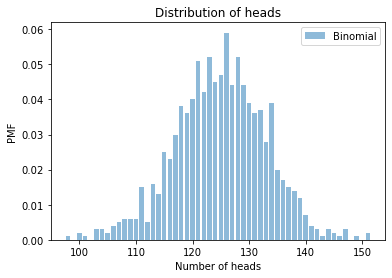

In [10]:
plot_pmf(sample_binomial, label='Binomial', alpha=0.5)
decorate_heads()

## The beta distribution

In [21]:
alpha = 2
beta = 2

sample_beta = pm.Beta.dist(alpha=alpha, beta=beta).random(size=1000)
sample_beta.mean()

0.49962730074485934

In [22]:
def decorate_proportion(ylabel='Density'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

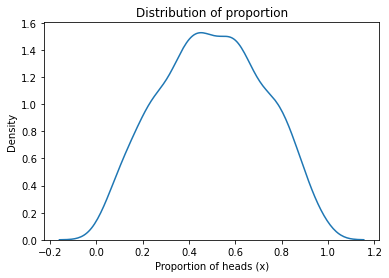

In [23]:
import seaborn as sns

sns.kdeplot(sample_beta)
decorate_proportion()

**Exercise:** See what the distribution looks like with different values of `alpha` and `beta`.

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here's what the PyMC model looks like:

In [63]:
alpha = 2
beta = 2
n = 250

In [51]:
with pm.Model() as model:
    x = pm.Beta('x', alpha=alpha, beta=alpha)
    k = pm.Binomial('k', n=n, p=x)
    trace = pm.sample_prior_predictive(1000)

In [52]:
sample_prior = trace['x']
np.mean(sample_prior)

0.5023380319518671

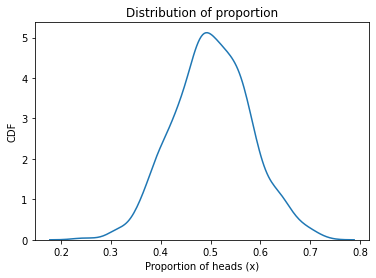

In [53]:
sns.kdeplot(sample_prior)
decorate_proportion('CDF')

## The prior predictive distribution


In [54]:
sample_prior_pred = trace['k']
sample_prior_pred.mean()

125.93

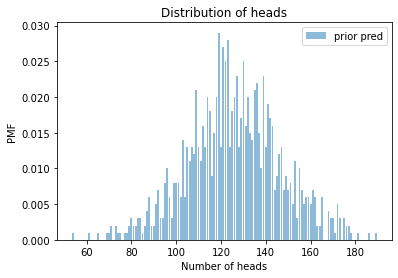

In [55]:
plot_pmf(sample_prior_pred, label='prior pred', alpha=0.5)
decorate_heads()

This distribution shows the distribution of goals we should expect in a game, based on the prior distribution only, not the data.

It is useful for model-checking, but it is also a step along the way to inference.

## When do we get to inference?


In [56]:
k_obs = 140

with pm.Model() as model:
    x = pm.Beta('x', alpha=2, beta=2)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  

In [57]:
len(trace['x'])

2000

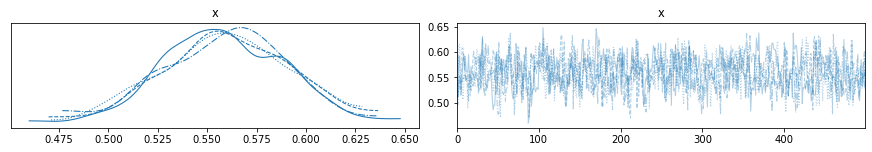

In [58]:
import arviz as az

with model:
    az.plot_trace(trace)

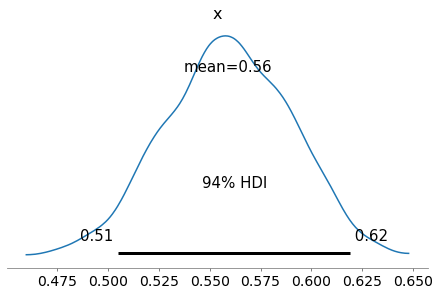

In [59]:
import arviz as az

with model:
    az.plot_posterior(trace)

## The posterior predictive distribution

In [60]:
with model:
    post_pred = pm.sample_posterior_predictive(trace)

In [61]:
sample_post_pred = post_pred['k']
sample_post_pred.mean()

139.66

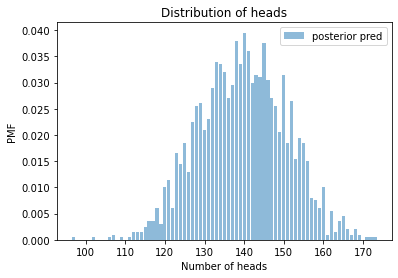

In [62]:
plot_pmf(sample_post_pred, label='posterior pred', alpha=0.5)
decorate_heads()

In [64]:
k_obs = 140
k_fair = 125

with pm.Model() as model:
    x1 = pm.Beta('x1', alpha=2, beta=2)
    x2 = pm.Beta('x2', alpha=2, beta=2)
    k1 = pm.Binomial('k1', n=n, p=x1, observed=k_obs)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=k_fair)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


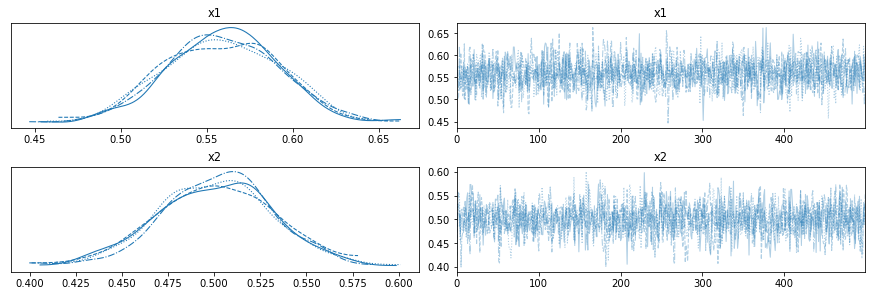

In [66]:
with model:
    az.plot_trace(trace)

In [67]:
np.mean(trace['x1'] > trace['x2'])

0.9055